In [2]:
import os
import numpy as np
import pydicom
import highdicom as hd
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
from highdicom.seg import Segmentation
from skimage import measure
from PIL import Image
from scipy import ndimage
from scipy.ndimage import center_of_mass
from skimage.segmentation import flood
from skimage import exposure
import scipy
import io
import utils
import cv2
from scipy.ndimage import label, center_of_mass, binary_closing, binary_fill_holes,binary_opening,binary_dilation,binary_erosion
from collections import deque
from sklearn.cluster import KMeans
from scipy.ndimage import label
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, find_objects
import pandas as pd
from skimage.morphology import remove_small_objects
import utils
%load_ext autoreload
%autoreload 2

## VOLUMEN

In [5]:
path = os.path.abspath(os.path.join(os.getcwd(), "0745", "10_AP_Ax5.00mm"))
print(f"Loading DICOM files from {path}")
slices = utils.load_dicom(path)

#Noise slice
slices = slices[1:]

img_dcm = utils.create_3d_array_from_dicom(slices)

print(f"3D image shape: {img_dcm.shape}")

Loading DICOM files from /Users/whiiz/Downloads/MIP_01/0745/10_AP_Ax5.00mm
3D image shape: (51, 512, 512)


## TUMOR

In [6]:
tumor_path = os.path.abspath(os.path.join(os.getcwd(),"0745", "10_AP_Ax5.00mm_ManualROI_Tumor.dcm"))
seg = hd.seg.segread(tumor_path)

mask = seg.pixel_array
print(f"Mask shape: {mask.shape}")
# 1. Obtain the Z positions of each slice of the original volume (CT)
ct_z_positions = [float(slice.ImagePositionPatient[2]) for slice in slices]

# 2. Obtain the Z positions of each slice of the tumor
tumor_z_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in seg.PerFrameFunctionalGroupsSequence
]

# 3. Mapping the tumor slice indices to the original volume
tumor_slice_indices = [ct_z_positions.index(z) for z in tumor_z_positions]

# 4. Creathe the empty mask
full_tumor_mask = np.zeros_like(img_dcm, dtype=np.uint8)

# 5. Assign each slice of the tumor to its position
for i, idx in enumerate(tumor_slice_indices):
    full_tumor_mask[idx] = mask[i]

print(f"Full tumor mask shape: {full_tumor_mask.shape}")

Mask shape: (12, 512, 512)
Full tumor mask shape: (51, 512, 512)


## Liver

In [7]:
liver_path = os.path.abspath(os.path.join(os.getcwd(),"0745", "10_AP_Ax5.00mm_ManualROI_Liver.dcm"))
seg_liver = hd.seg.segread(liver_path)

mask = seg_liver.pixel_array

# 1. Obtain the Z positions of each slice of the original volume (CT)
ct_z_positions = [float(slice.ImagePositionPatient[2]) for slice in slices]

# 2. Obtain the Z positions of each slice of the tumor
liver_z_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in seg_liver.PerFrameFunctionalGroupsSequence
]

# 3. Mapping the tumor slice indices to the original volume
liver_slice_indices = [ct_z_positions.index(z) for z in liver_z_positions]

# 4. Creathe the empty mask
full_liver_mask = np.zeros_like(img_dcm, dtype=np.uint8)

# 5. Assign each slice of the tumor to its position
for i, idx in enumerate(liver_slice_indices):
    full_liver_mask[idx] = mask[i]

print(f"Full mask shape: {full_liver_mask.shape}")

Full mask shape: (51, 512, 512)


In [8]:
##HOUNSFIELD CONVERSION
ct_volume_hu, voxel_spacing = utils.convert_to_hounsfield(slices)
print("Shape del volumen:", ct_volume_hu.shape)

Shape del volumen: (51, 512, 512)


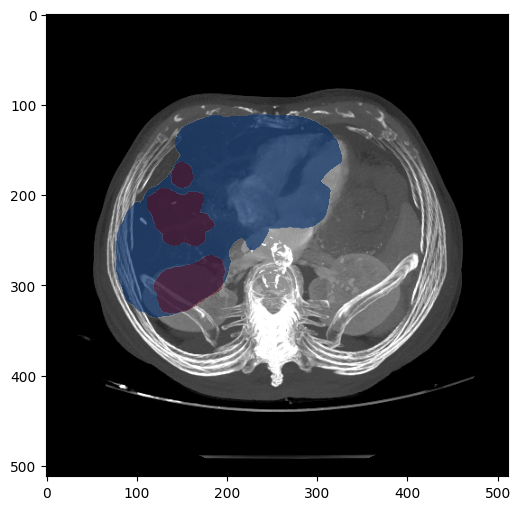

In [98]:
#SHOWING MIP IMAGE
windowed_img = utils.window_image(ct_volume_hu, center=300, width=1000)
mip_img = np.max(windowed_img, axis=0) 
mask_tumor = np.max(full_tumor_mask, axis=0)
mask_liver = np.max(full_liver_mask, axis=0)
utils.show_mip_with_two_masks(mip_img,mask_liver, mask_tumor, alpha_liver=0.65, alpha_tumor=0.45
                        ,cmap_mip="gray",cmap_liver='Blues', cmap_tumor='Reds',aspect=1)

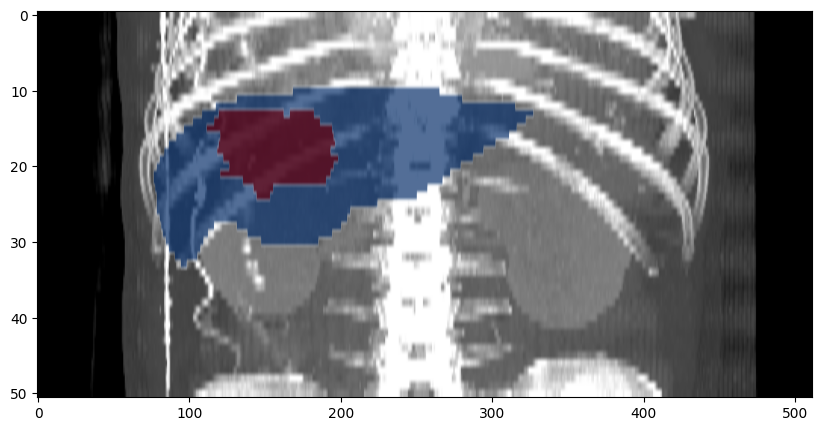

In [13]:
utils.show_mip_with_two_masks(
    mip_img=np.max(windowed_img, axis=1),
    mask_liver=np.max(full_liver_mask, axis=1),
    mask_tumor=np.max(full_tumor_mask, axis=1),
    bbox=None,
    centroid=None,
    plane='axial',
    cmap_mip='gray', cmap_liver='Blues', cmap_tumor='Reds',
    aspect=5,
    alpha_liver=0.7 , alpha_tumor=0.7
)

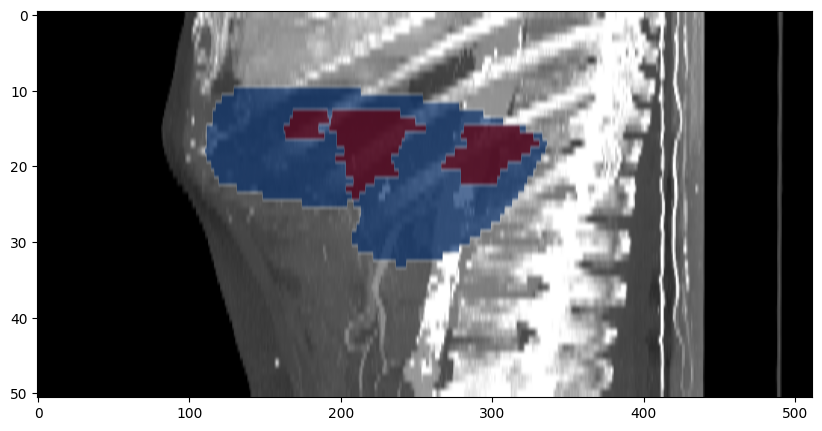

In [14]:
utils.show_mip_with_two_masks(
    mip_img=np.max(windowed_img, axis=2),
    mask_liver=np.max(full_liver_mask, axis=2),
    mask_tumor=np.max(full_tumor_mask, axis=2),
    bbox=None,
    centroid=None,
    plane='sagittal',
    cmap_mip='gray', cmap_liver='Blues', cmap_tumor='Reds',
    aspect=5,
    alpha_liver=0.7 , alpha_tumor=0.7
)

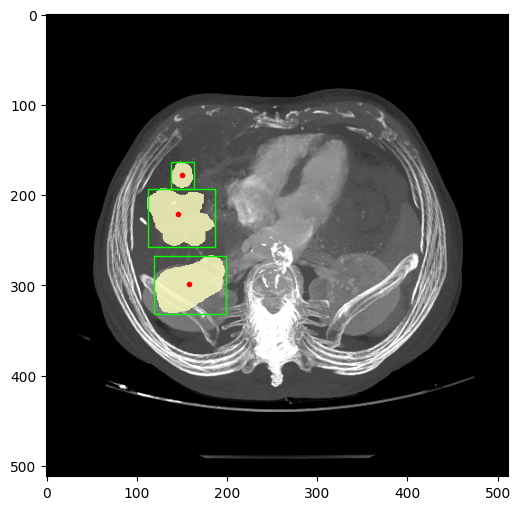

In [92]:
labeled_gt, n_gt = label(full_tumor_mask)
bboxes = find_objects(labeled_gt)
bboxes = [[(bbox[0].start, bbox[0].stop), (bbox[1].start, bbox[1].stop), (bbox[2].start, bbox[2].stop)] for bbox in bboxes if bbox is not None]
centroids = [tuple(map(int, center_of_mass(labeled_gt == (i + 1)))) for i in range(n_gt)]
utils.show_mip_with_two_masks(mip_img, None, mask_tumor, alpha_liver=0.65, alpha_tumor=0.85,
                        cmap_mip="gray", cmap_liver='Blues', cmap_tumor='magma', aspect=1, bbox=bboxes, centroid=centroids)

Number of voxels marked as liver (excluding tumor): 92005.51299999998


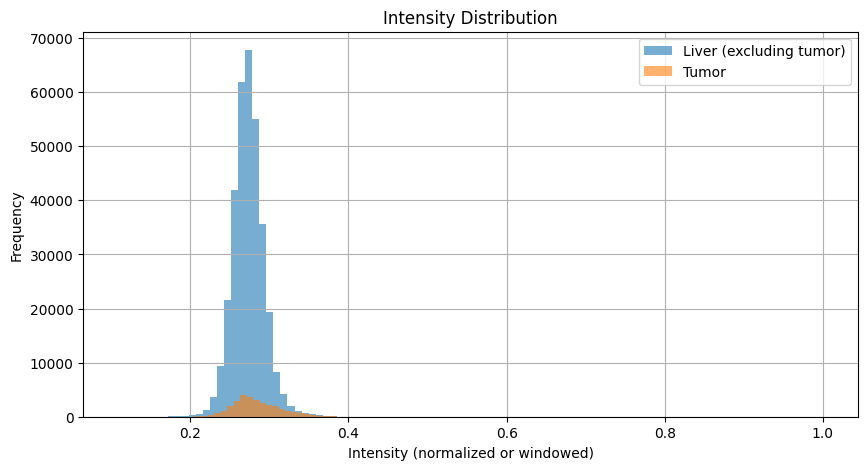

In [94]:

liver_only_mask = (full_liver_mask == 1) & (full_tumor_mask == 0)
tumor_mask = (full_tumor_mask == 1)

liver_values = windowed_img[liver_only_mask]
tumor_values = windowed_img[tumor_mask]

num_liver_voxels = np.sum(liver_values)
print(f"Number of voxels marked as liver (excluding tumor): {num_liver_voxels}")

plt.figure(figsize=(10, 5))
plt.hist(liver_values, bins=100, alpha=0.6, label='Liver (excluding tumor)')
plt.hist(tumor_values, bins=100, alpha=0.6, label='Tumor')
plt.title("Intensity Distribution")
plt.xlabel("Intensity (normalized or windowed)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

🔍 Detected 3 disconnected tumor regions.


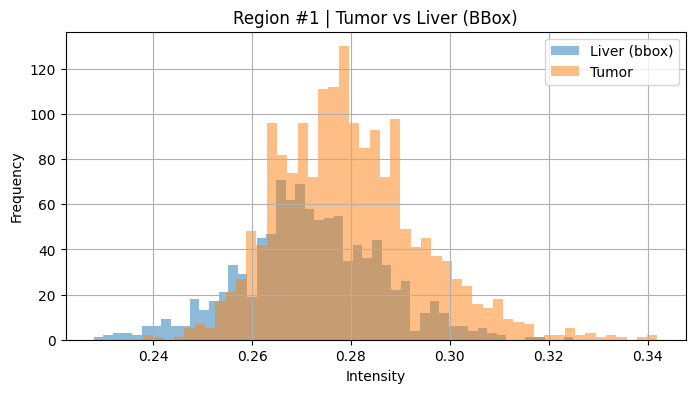

🧠 Region #1: tumor_mean=0.280 ± 1·std = [0.265, 0.294]
Number of tumor voxels: 1745
Number of liver voxels: 1020


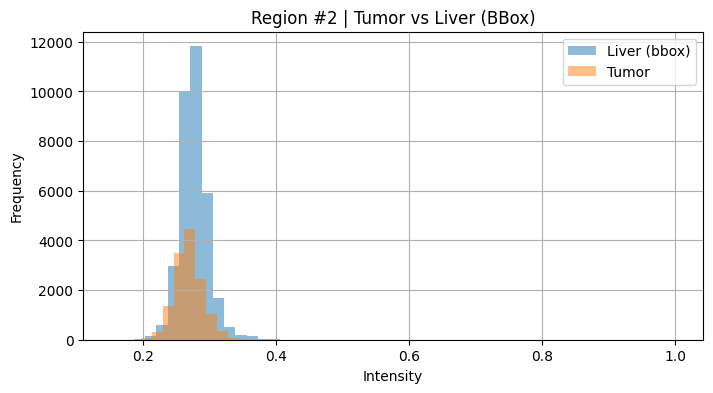

🧠 Region #2: tumor_mean=0.270 ± 1·std = [0.246, 0.293]
Number of tumor voxels: 13577
Number of liver voxels: 34024


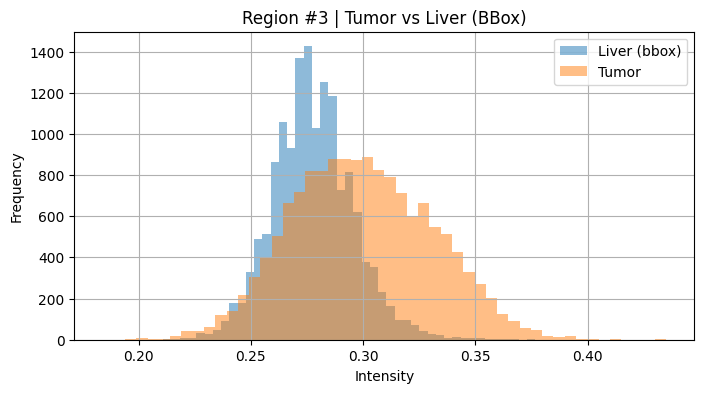

🧠 Region #3: tumor_mean=0.300 ± 1·std = [0.268, 0.331]
Number of tumor voxels: 14665
Number of liver voxels: 14724


In [16]:
stats = utils.analyze_tumor_vs_liver_per_component(windowed_img, full_tumor_mask, full_liver_mask,k=1)

# MIP GIF

In [ ]:
utils.generate_mip_gif(
    ct_volume=windowed_img,             # Volumen ya normalizado y con contraste aplicado
    liver_mask=full_liver_mask,    # Máscara binaria del hígado
    tumor_mask=full_tumor_mask,    # Máscara binaria del tumor
    output_path="mip_liver_tumor.gif",
    alpha_liver=0.8, alpha_tumor=0.5,
    aspect=5
)

## Segmentation

In [ ]:
def region_growing_weighted(volume, seed, min_val, max_val, mask_limit, max_distance=20, use_soft_decay=False):
    """
    Region growing with distance-based penalty.

    Parameters:
    - volume: 3D volume
    - seed: coordinates (z, y, x) of the seed voxel
    - min_val, max_val: intensity threshold
    - mask_limit: 3D binary mask where growth is allowed (e.g., liver)
    - max_distance: maximum distance from the seed
    - use_soft_decay: if True, the threshold adjusts with distance

    Returns:
    - result_mask: binary mask with the segmented region
    """
    shape = volume.shape
    visited = np.zeros(shape, dtype=bool)
    result_mask = np.zeros(shape, dtype=np.uint8)
    queue = deque()
    queue.append((seed, 0))  # seed: (z, y, x), dist: 0

    ref_val = volume[seed]  # intensidad del seed original

    while queue:
        (z, y, x), dist = queue.popleft()
        if not (0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]):
            continue
        if visited[z, y, x] or mask_limit[z, y, x] == 0:
            continue
        if dist > max_distance:
            continue

        visited[z, y, x] = True
        val = volume[z, y, x]

        # Ajuste del umbral si se activa soft decay
        if use_soft_decay:
            decay_margin = (1 - dist / max_distance) * (max_val - min_val)
            dynamic_min = ref_val - decay_margin
            dynamic_max = ref_val + decay_margin
        else:
            dynamic_min = min_val
            dynamic_max = max_val

        if dynamic_min <= val <= dynamic_max:
            result_mask[z, y, x] = 1
            for dz in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dz == dy == dx == 0:
                            continue
                        queue.append(((z + dz, y + dy, x + dx), dist + 1))

    return result_mask


def segment_by_components_distance(volume, mask_tumor, mask_liver,
                                   intensity_threshold=0.1,
                                   clean=True, smth=True, value_smooth=0.9,
                                   max_distance=20, use_soft_decay=True):
    """
    Segments tumor regions by components using distance-weighted region growing.

    Parameters:
    - volume: 3D image (windowed)
    - mask_tumor: binary mask with tumors (ground truth)
    - mask_liver: binary mask of the liver
    - intensity_threshold: intensity threshold ± relative to the seed value
    - clean: apply morphological cleaning
    - smth: apply Gaussian smoothing
    - value_smooth: threshold after smoothing
    - max_distance: global integer or list of distances per component
    - use_soft_decay: if True, adjusts the intensity range with distance

    Returns:
    - full_mask: final binary mask
    """
    labeled_gt, n_gt = label(mask_tumor)
    print(f"Detected {n_gt} disconnected tumor regions in the ground truth.")
    bboxes = find_objects(labeled_gt)

    # Adapt max_distance
    if isinstance(max_distance, list):
        assert len(max_distance) == n_gt, "Length of max_distance list must match number of tumor components."
        max_d_list = max_distance
    else:
        max_d_list = [max_distance] * n_gt

    full_mask = np.zeros_like(mask_tumor, dtype=np.uint8)

    for i, bbox in enumerate(bboxes):
        if bbox is None:
            continue

        z0, z1 = bbox[0].start, bbox[0].stop
        y0, y1 = bbox[1].start, bbox[1].stop
        x0, x1 = bbox[2].start, bbox[2].stop

        crop_vol = volume[z0:z1, y0:y1, x0:x1]
        crop_liver = mask_liver[z0:z1, y0:y1, x0:x1]
        crop_tumor = (labeled_gt[z0:z1, y0:y1, x0:x1] == (i + 1))

        # Centroid as seed
        seed = tuple(map(int, center_of_mass(crop_tumor)))
        if not all(0 <= s < d for s, d in zip(seed, crop_vol.shape)):
            continue

        ref_val = crop_vol[seed]
        min_val = ref_val - intensity_threshold
        max_val = ref_val + intensity_threshold

        # Region growing limited to the liver
        seg_local = region_growing_weighted(
            volume=crop_vol,
            seed=seed,
            min_val=min_val,
            max_val=max_val,
            mask_limit=crop_liver,
            max_distance=max_d_list[i],
            use_soft_decay=use_soft_decay
        )

        seg_local = (seg_local & (crop_liver == 1)).astype(np.uint8)
        seg_local = binary_fill_holes(seg_local).astype(np.uint8)

        if clean:
            seg_local = binary_opening(seg_local, structure=np.ones((3, 3, 3))).astype(np.uint8)

        if smth:
            smoothed = gaussian_filter(seg_local.astype(float), sigma=1)
            seg_local = (smoothed > value_smooth).astype(np.uint8)

        full_mask[z0:z1, y0:y1, x0:x1] |= seg_local

    return full_mask


In [ ]:
segmented_mask = segment_by_components_distance(windowed_img, full_tumor_mask,full_liver_mask, intensity_threshold=0.2,value_smooth=0.8 ,clean=True,
                                                smth=False, max_distance=[10,20,30], use_soft_decay=True)

num_ones = np.sum(segmented_mask == 1)
print(f"Number of values equal to 1 in the segmented mask: {num_ones}")

Detected 3 disconnected tumor regions in the ground truth.
Number of values equal to 1 in the segmented mask: 27270


## Evaluation

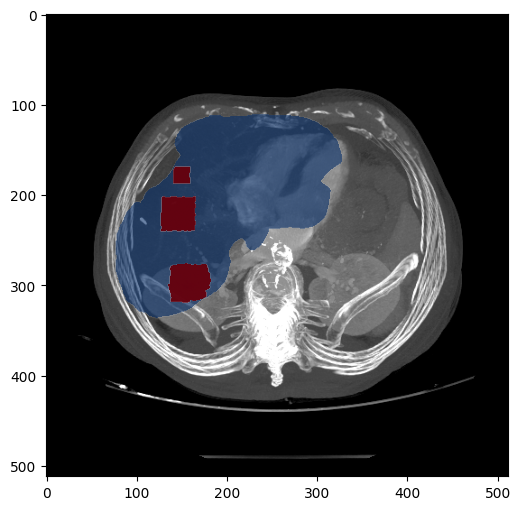

In [93]:
mip_coronal = np.max(windowed_img, axis=0)
mip_mask_liver = np.max(full_liver_mask, axis=0)
mip_mask_tumor = np.max(segmented_mask, axis=0)

#axial & axis = 1 coronal & axis = 0 sagittal & axis = 2
utils.show_mip_with_two_masks(
    mip_img=mip_coronal,
    mask_liver=mip_mask_liver,
    mask_tumor=mip_mask_tumor,
    bbox=None,
    centroid=None,
    plane='coronal',
    cmap_mip='gray', cmap_liver='Blues', cmap_tumor='Reds',
    aspect=1,
    alpha_liver=0.6 , alpha_tumor=0.95
)

In [26]:
utils.plot_slices_with_two_masks(
    volume=windowed_img,
    mask1=full_liver_mask,
    mask2=segmented_mask,
    cmap1='Blues',
    cmap2='Reds',
    alpha1=0.95,
    alpha2=0.8,
    save_path="overlay_segmentation.png"
)

✅ File saved as: overlay_segmentation.png


In [ ]:
utils.plot_slices_with_two_masks(
    volume=windowed_img,
    mask1=segmented_mask,
    mask2=full_tumor_mask,
    cmap1='magma',
    cmap2='Reds',
    alpha1=0.99,
    alpha2=0.6,
    save_path="overlay_tumor_masks.png"
)

✅ File saved as: overlay_tumor_masks2.png


## Metrics

In [95]:
def evaluate_per_tumor_bbox(mask_gt, mask_pred):
    labeled_gt, n_gt = label(mask_gt)
    bboxes = find_objects(labeled_gt)
    
    results = []

    for i, bbox in enumerate(bboxes):
        if bbox is None:
            continue

        # Recorte local del volumen
        crop_gt = (labeled_gt[bbox] == (i + 1)).astype(np.uint8)
        crop_pred = mask_pred[bbox]

        TP = np.logical_and(crop_gt, crop_pred).sum()
        FP = np.logical_and(~crop_gt.astype(bool), crop_pred).sum()
        FN = np.logical_and(crop_gt, ~crop_pred.astype(bool)).sum()
        TN = np.logical_and(~crop_gt.astype(bool), ~crop_pred.astype(bool)).sum()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        accuracy = (TP + TN) / (TP + FP + FN + TN + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        results.append({
            'tumor_index': i + 1,
            'bbox': bbox,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'f1_score': f1
        })

    return results

In [97]:
metrics = evaluate_per_tumor_bbox(mask_gt=full_tumor_mask, mask_pred=segmented_mask)

# Perform evaluation & Create DataFrame
df_metrics = pd.DataFrame(metrics)

# Round metrics to 3 decimal places
for col in ['precision', 'recall', 'accuracy', 'f1_score']:
    df_metrics[col] = df_metrics[col].round(3)

# Display the table
print(df_metrics[['tumor_index', 'TP', 'FP', 'FN','TN', 'precision', 'recall', 'accuracy', 'f1_score']])



   tumor_index    TP    FP    FN     TN  precision  recall  accuracy  f1_score
0            1  1298   106   447   1149      0.925   0.744     0.816     0.824
1            2  8876  5367  4701  38656      0.623   0.654     0.825     0.638
2            3  9603  2020  5062  24915      0.826   0.655     0.830     0.731
